<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad_Feb22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
#import math

import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


# Funciones

In [2]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura de datos

In [3]:
file = 'C:\\Users\\conte\\OneDrive\\Escritorio\\Secretaria Energia\\SARIMA\\TD_S_SescoWebUP_07_2022.csv'
datos = pd.read_csv(file, usecols=['Date','TotalGas'])
datos

,Date,TotalGas
0,1/1/2009,135493.2462
1,2/1/2009,119567.3700
2,3/1/2009,132671.8891
3,4/1/2009,116012.7545
4,5/1/2009,108534.5693
...,...,...
158,3/1/2022,144416.8986
159,4/1/2022,124820.8609
160,5/1/2022,117977.1775
161,6/1/2022,121233.9448


In [4]:
datos["Date"] = pd.to_datetime(datos["Date"])

datos = datos.set_index('Date')

In [5]:
datos['1000TotalGas'] = datos['TotalGas']/1000

In [6]:
datos.describe()

,TotalGas,1000TotalGas
count,163.000000,163.000000
mean,123918.355905,123.918356
std,7495.472834,7.495473
min,105860.819600,105.860820
25%,117651.243200,117.651243
50%,123464.276900,123.464277
75%,128298.842800,128.298843
max,144420.969600,144.420970


In [7]:
datos.index.is_monotonic

True

In [8]:
datos.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='Date', length=163, freq=None)

In [9]:
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='Date', length=163, freq='MS')

# Exploración y Visualización de la Serie Temporal

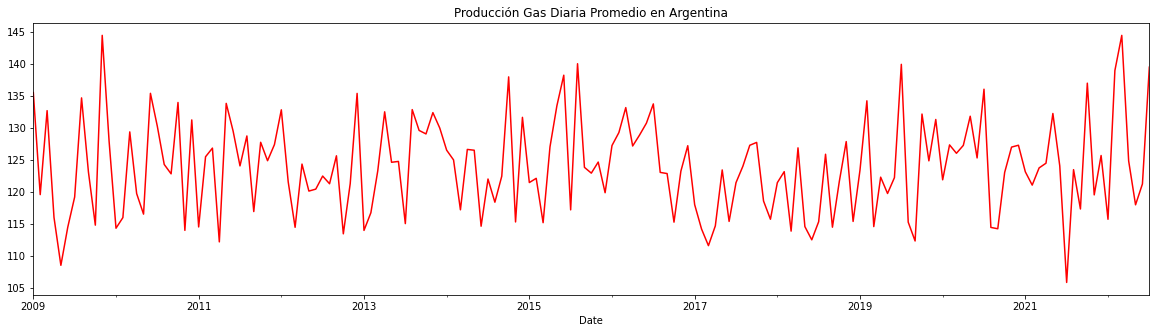

In [10]:
datos['1000TotalGas'].plot(figsize=(20,5), title='Producción Gas Diaria Promedio en Argentina', color='red')
plt.show()

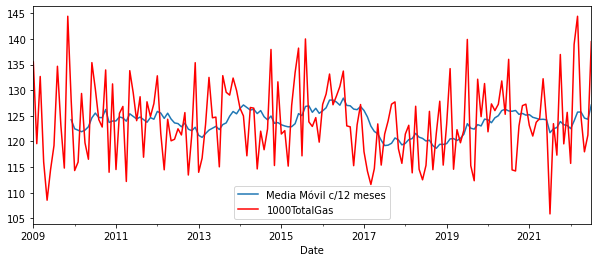

In [11]:
datos['1000TotalGas'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['1000TotalGas'].plot(color='red')
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

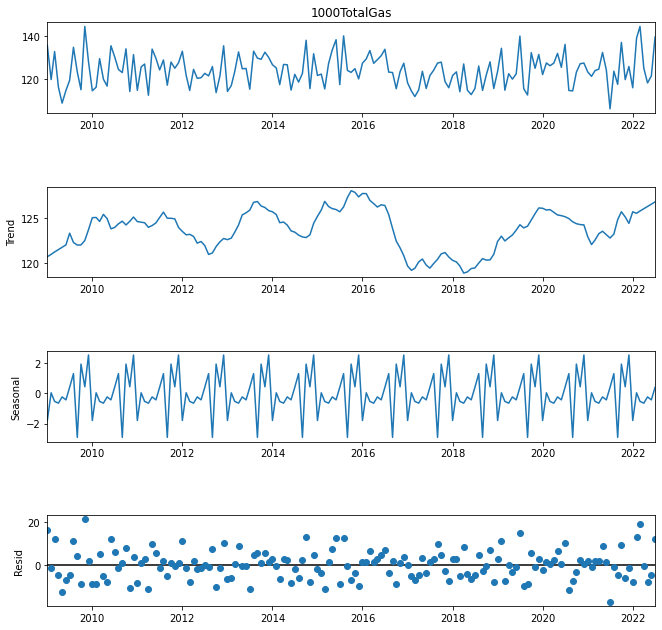

In [12]:
decomp = seasonal_decompose(datos['1000TotalGas'], period=12, extrapolate_trend='freq')
fig = decomp.plot()
fig.set_size_inches(10,10)

# Convertir los datos a Estacionarios

Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [13]:
pValue = adfuller(datos['1000TotalGas'])[1]
pValue

9.943246466699496e-24

In [14]:
p_value_adfuller(datos['1000TotalGas'])

P-value:  9.943246466699496e-24
Se rechaza la hipótesis nula, los datos son estacionarios


# Visualización de la ACF y PACF

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


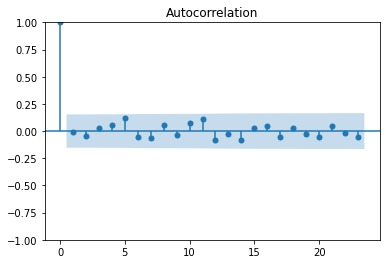

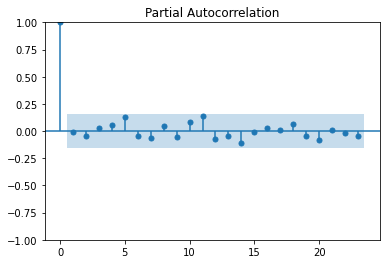

In [15]:
plot_acf(datos['1000TotalGas'])
plot_pacf(datos['1000TotalGas'])
plt.show()

# Construcción del modelo SARIMA



In [16]:
train = datos.loc[:'2022-1-1','1000TotalGas']
test = datos.loc['2022-1-1':,'1000TotalGas']

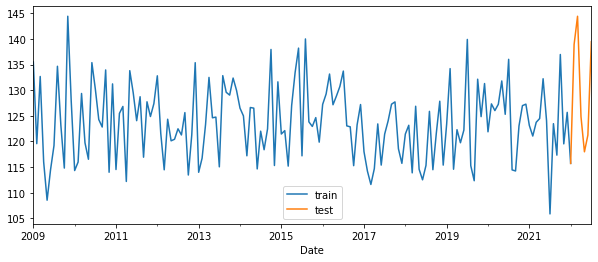

In [17]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

In [18]:
100*len(test)/len(train)

4.45859872611465

In [19]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d , q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [20]:
p = d =  q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [21]:
aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(datos.loc[:'2022-1-1','1000TotalGas'],
                       order = parametros,
                       seasonal_order = parametros_s,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
      results = modelo.fit()#method_kwargs={"warn_convergence": False}
      aic_modelos[parametros, parametros_s] = results.aic
      # print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))  

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [34]:
print('Modelo: ', min(aic_modelos, key = aic_modelos.get))
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((0, 2, 2), (0, 2, 2, 12))
AIC:  773.897089274446


In [35]:
modelo = SARIMAX(datos['1000TotalGas'],
                       order = (0,2,2),
                       seasonal_order = (0,2,2,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.1025    503.173     -0.004      0.997    -988.304     984.099
ma.L2          1.1025    554.756      0.002      0.998   -1086.198    1088.403
ma.S.L12      -1.8303    151.691     -0.012      0.990    -299.140     295.479
ma.S.L24       1.0003    165.778      0.006      0.995    -323.920     325.920
sigma2        53.2627   2.76e+04      0.002      0.998   -5.41e+04    5.42e+04


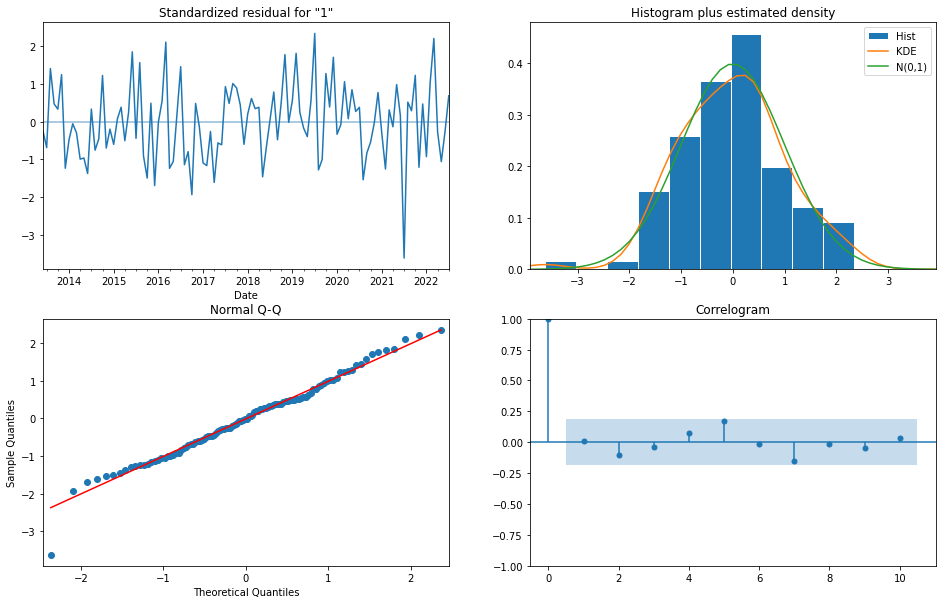

In [36]:
resultados.plot_diagnostics(figsize = (16,10))
plt.show()

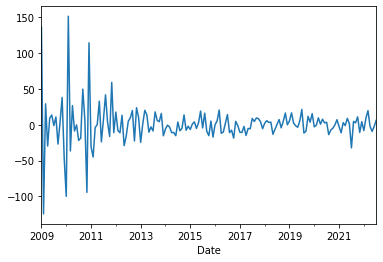

In [37]:
resultados.resid.plot()
plt.show()

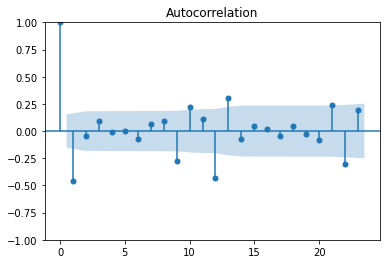

In [38]:
plot_acf(resultados.resid)
plt.show()

c:\Users\conte\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


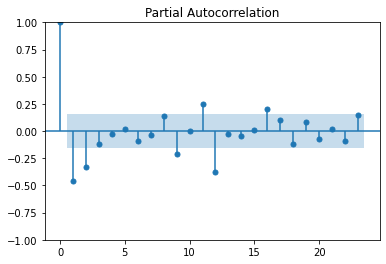

In [39]:
plot_pacf(resultados.resid)
plt.show()

# Validación

In [40]:
pred = resultados.get_prediction(start=pd.to_datetime('2022-01-01'),
                                 end=pd.to_datetime('2025-01-01'))
pred.predicted_mean

2022-01-01    123.993524
2022-02-01    129.775945
2022-03-01    124.861596
2022-04-01    127.245041
2022-05-01    127.363541
2022-06-01    123.528781
2022-07-01    133.398807
2022-08-01    121.566888
2022-09-01    116.043037
2022-10-01    133.510902
2022-11-01    132.330998
2022-12-01    127.397593
2023-01-01    124.444782
2023-02-01    138.046023
2023-03-01    137.574138
2023-04-01    127.803940
2023-05-01    126.826727
2023-06-01    126.098849
2023-07-01    139.021707
2023-08-01    122.448259
2023-09-01    116.249889
2023-10-01    138.789561
2023-11-01    136.717881
2023-12-01    132.192878
2024-01-01    126.205162
2024-02-01    143.989568
2024-03-01    147.309750
2024-04-01    130.673992
2024-05-01    129.435945
2024-06-01    129.845826
2024-07-01    144.345094
2024-08-01    124.529218
2024-09-01    117.668432
2024-10-01    145.292011
2024-11-01    142.340658
2024-12-01    138.236158
2025-01-01    129.225639
Freq: MS, Name: predicted_mean, dtype: float64

In [41]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower 1000TotalGas,upper 1000TotalGas
2022-01-01,106.562022,141.425025
2022-02-01,112.403139,147.148751
2022-03-01,107.510877,142.212315
2022-04-01,109.912843,144.577238
2022-05-01,110.047024,144.680058
2022-06-01,106.225626,140.831936
2022-07-01,116.107112,150.690502
2022-08-01,104.285082,138.848694
2022-09-01,98.662745,133.423330
2022-10-01,116.030744,150.991060


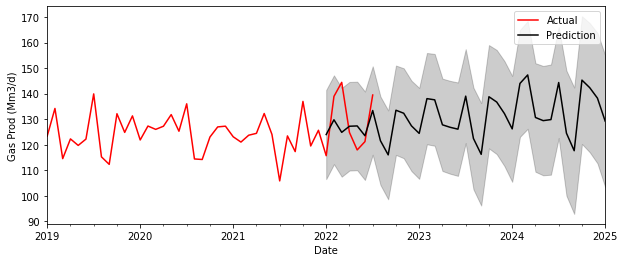

In [46]:
fig = datos.loc['2019-01-01':,'1000TotalGas'].plot(label = 'Actual', 
                                           figsize =(10,4), color='red')
pred.predicted_mean.plot(ax = fig, label = 'Prediction', color='black')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.ylabel('Gas Prod (Mm3/d)')
plt.legend()
plt.show()

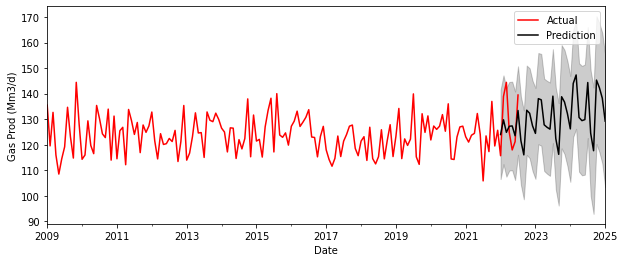

In [47]:
fig = datos.loc['2009-01-01':,'1000TotalGas'].plot(label = 'Actual', 
                                           figsize =(10,4), color='red')
pred.predicted_mean.plot(ax = fig, label = 'Prediction', color='black')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.ylabel('Gas Prod (Mm3/d)')
plt.legend()
plt.show()

In [44]:
y_pred  = pred.predicted_mean
y_real = datos.loc['2022-01-01':'2025-01-01','1000TotalGas']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 3)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 3)))

El error cuadrático medio es 95.796
La raiz del error cuadrático medio es 9.788


In [45]:
print(f"Porcentaje de error con respecto al promedio: {round(100*np.sqrt(mse)/(datos['1000TotalGas'].mean()), 3)} %")

Porcentaje de error con respecto al promedio: 7.898 %
